# Random Forest Implementation

## Preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [3]:
# Define the preprocess_df function
def preprocess_df(df, trained_columns):
    # Define features to drop, including IP addresses, ports, and other specified features
    features_to_drop = ['src_ip', 'dst_ip', 'src_port', 'service','dst_port', 'ssl_version', 'ssl_cipher', 'ssl_subject', 'ssl_issuer','dns_query','dns_qclass','dns_qtype','dns_rcode','http_request_body_len','http_version', 'http_trans_depth','http_method','http_uri','http_response_body_len','http_status_code','http_user_agent','http_orig_mime_types','http_resp_mime_types','weird_name','weird_addl','weird_notice']

    # Check if 'ts' column exists, and drop it if it does
    if 'ts' in df.columns:
        features_to_drop.append('ts')

    df = df.drop(columns=features_to_drop)

    # Exclude 'type' from the list of categorical columns for encoding
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    categorical_cols.remove('type')  # Exclude 'type' column

    # Fill missing numeric values with the median
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

    # Fill missing categorical values with the mode (excluding 'type')
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

    # Encode the categorical variables (excluding 'type')
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.reindex(columns=trained_columns, fill_value=0)

    # Proceed with scaling the numeric features
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


In [4]:
# Load the dataset
data_path = 'train_test_network.csv'
df = pd.read_csv(data_path)

# Define features to drop, including IP addresses, ports, and other specified features
features_to_drop = ['src_ip', 'dst_ip', 'src_port', 'service','dst_port', 'ssl_version', 'ssl_cipher', 'ssl_subject', 'ssl_issuer','dns_query','dns_qclass','dns_qtype','dns_rcode','http_request_body_len','http_version', 'http_trans_depth','http_method','http_uri','http_response_body_len','http_status_code','http_user_agent','http_orig_mime_types','http_resp_mime_types','weird_name','weird_addl','weird_notice']
df = df.drop(columns=features_to_drop)

In [5]:
# Exclude 'type' from the list of categorical columns for encoding
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols.remove('type')  # Exclude 'type' column

# Fill missing numeric values with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Fill missing categorical values with the mode (excluding 'type')
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Encode the categorical variables (excluding 'type')
df = pd.get_dummies(df, columns=categorical_cols)

# Proceed with scaling the numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# After preprocessing your training data
trained_columns = df.columns.tolist()

## Training model

In [6]:
# Separate the features (X) from the target variable (y)
X = df.drop('type', axis=1)  # Features
y = df['type']  # Target variable

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the splits
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 168834 rows
Testing set size: 42209 rows


In [7]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=5, criterion='entropy', random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=42)

In [8]:
# Evaluate the model on the testing set
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      3919
        ddos       0.98      0.97      0.98      4065
         dos       0.99      0.99      0.99      3934
   injection       0.96      0.97      0.97      3978
        mitm       0.77      0.78      0.78       213
      normal       1.00      1.00      1.00     10021
    password       0.99      0.98      0.98      3968
  ransomware       0.91      0.98      0.95      4047
    scanning       0.99      0.99      0.99      4015
         xss       0.95      0.90      0.93      4049

    accuracy                           0.98     42209
   macro avg       0.96      0.96      0.96     42209
weighted avg       0.98      0.98      0.98     42209



## Visualization

In [9]:
# Undestanding the number of trees in the random forest
num_trees = rf_classifier.n_estimators
print("Number of trees in the Random Forest:", num_trees)

Number of trees in the Random Forest: 5


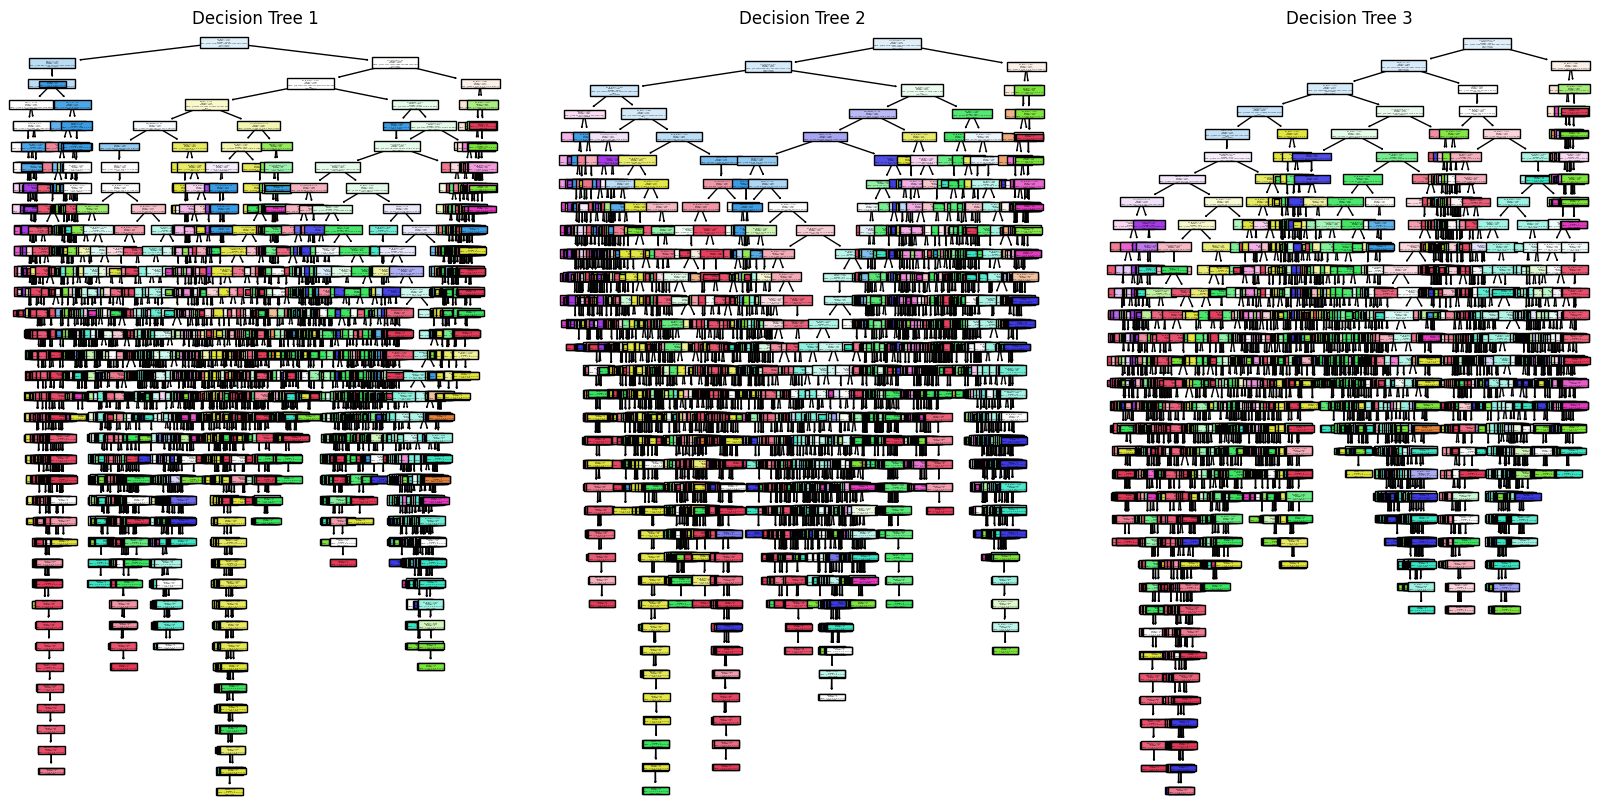

In [10]:
# Plotting individual trees in the Random Forest
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_tree(rf_classifier.estimators_[i], filled=True, feature_names=X.columns, class_names=y.unique())
    plt.title(f'Decision Tree {i+1}')
plt.show()


## Testing

The following datasets can be found at: https://research.unsw.edu.au/projects/unsw-nb15-dataset

Network_dataset_10 contains instances of normal traffic and dos attacks

In [12]:
# Load and preprocess the new dataset
new_data = pd.read_csv('Network_dataset_10.csv')
new_data = preprocess_df(new_data, trained_columns)

# Separate features (X_new_data) from the target variable (y_new_data)
X_new_data = new_data.drop('type', axis=1)
y_new_data = new_data['type']

# Ensure feature names match those seen during training
new_X = X_new_data.reindex(columns=X.columns, fill_value=0)

# Predict using the trained model
new_y_pred = rf_classifier.predict(new_X)

# Evaluate the model
new_accuracy = accuracy_score(y_new_data, new_y_pred)
new_report = classification_report(y_new_data, new_y_pred)

# Print the accuracy and classification report
print(f'Accuracy of the Random Forest model on the new dataset: {new_accuracy:.2f}')
print('Classification Report for the new dataset:\n', new_report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of the Random Forest model on the new dataset: 0.96
Classification Report for the new dataset:
               precision    recall  f1-score   support

    backdoor       0.00      0.00      0.00         0
        ddos       0.00      0.00      0.00         0
         dos       1.00      0.95      0.98    969998
   injection       0.00      0.00      0.00         0
        mitm       0.00      0.00      0.00         0
      normal       1.00      1.00      1.00     30002
         xss       0.00      0.00      0.00         0

    accuracy                           0.96   1000000
   macro avg       0.29      0.28      0.28   1000000
weighted avg       1.00      0.96      0.98   1000000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Load and preprocess the new dataset
new_data = pd.read_csv('Network_dataset_17.csv')
new_data = preprocess_df(new_data, trained_columns)

# Separate features (X_new_data) from the  variable (y_new_data)
X_new_data = new_data.drop('type', axis=1)
y_new_data = new_data['type']

# Ensure feature names match those seen during training
new_X = X_new_data.reindex(columns=X.columns, fill_value=0)

# Predict using the trained model
new_y_pred = rf_classifier.predict(new_X)

# Evaluate the model
new_accuracy = accuracy_score(y_new_data, new_y_pred)
new_report = classification_report(y_new_data, new_y_pred)

# Print the accuracy and classification report
print(f'Accuracy of the Random Forest model on the new dataset: {new_accuracy:.2f}')
print('Classification Report for the new dataset:\n', new_report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of the Random Forest model on the new dataset: 0.65
Classification Report for the new dataset:
               precision    recall  f1-score   support

        ddos       1.00      0.64      0.78    966289
         dos       0.00      0.00      0.00         0
   injection       0.00      0.00      0.00         0
        mitm       0.00      0.00      0.00         0
      normal       1.00      1.00      1.00     33711
    password       0.00      0.00      0.00         0
         xss       0.00      0.00      0.00         0

    accuracy                           0.65   1000000
   macro avg       0.29      0.23      0.25   1000000
weighted avg       1.00      0.65      0.79   1000000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Load and preprocess the new dataset
new_data = pd.read_csv('Network_dataset_11.csv')
new_data = preprocess_df(new_data, trained_columns)

# Separate features (X_new_data) from the  variable (y_new_data)
X_new_data = new_data.drop('type', axis=1)
y_new_data = new_data['type']

# Ensure feature names match those seen during training
new_X = X_new_data.reindex(columns=X.columns, fill_value=0)

# Predict using the trained model
new_y_pred = rf_classifier.predict(new_X)

# Evaluate the model
new_accuracy = accuracy_score(y_new_data, new_y_pred)
new_report = classification_report(y_new_data, new_y_pred)

# Print the accuracy and classification report
print(f'Accuracy of the Random Forest model on the new dataset 11: {new_accuracy:.2f}')
print('Classification Report for the new dataset 11:\n', new_report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of the Random Forest model on the new dataset 11: 0.88
Classification Report for the new dataset 11:
               precision    recall  f1-score   support

    backdoor       0.00      0.00      0.00         0
        ddos       0.00      0.00      0.00         0
         dos       0.91      0.98      0.94    839637
   injection       1.00      0.15      0.27    125195
        mitm       0.00      0.00      0.00         0
      normal       0.98      1.00      0.99     35168
    password       0.00      0.00      0.00         0
  ransomware       0.00      0.00      0.00         0
         xss       0.00      0.00      0.00         0

    accuracy                           0.88   1000000
   macro avg       0.32      0.24      0.24   1000000
weighted avg       0.93      0.88      0.86   1000000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
